# Figure out Sample Sizes for your Study: Two Proportion Z test

One important up front activity in empirical research is figuring out the sample size you need. This is a crucial, since it significantly impacts the cost of your study and the reliability of your results. Collect too much sample: you’ve wasted money and time. Collect too little: your results may be useless.

Understanding the sample size you need depends on the statistical test you plan to use. If it’s a straightforward test, then finding the desired sample size can be just a matter of plugging numbers into an equation. In this example, I’ll go through one of these more difficult cases.

> Here’s the scenario: you are doing a study on a marketing effort that’s intended to increase the proportion of women entering your store (say, a change in signage). Suppose you want to know whether the change actually increased the proportion of women walking through. You’re planning on collecting the data before and after you change the signs and determine if there’s a difference. You’ll be using a two-proportion Z test for comparing the two proportions. You’re unsure how long you’ll need to collect the data to get reliable results — you first have to figure out how much sample you need!

## Overview of the Two Proportion Z test

The first step in determining the required sample size is understanding the statical test you’ll be using. The two sample Z test for proportions determines whether a population proportion p1 is equal to another population proportion p2. In our example, p1 and p2 are the proportion of women entering the store before and after the marketing change (respectively), and we want to see whether there was a statistically significant increase in p2 over p1, i.e. p2 > p1.

For more information click [here](https://online.stat.psu.edu/stat414/node/268/).

## Figuring out Possibilities for Sample Sizes with Python

Ultimately, we want to make sure we’re able to calculate a difference between p1 and p2 when it exists. So, let’s assume you know that the “true” difference that exists between p1 and p2. Then, we can look at sample size requirements for various confidence levels and absolute levels of p1.

In [1]:
%matplotlib inline
import math
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

We need a way of figuring out Z, so we can determine whether a given sample size provides statistically significant results, so let’s define a function that returns the Z value given p1, p2, n1, and n2.

In [2]:
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

Then, we can define a function that returns the sample required, given p1 (the before probability), p_diff (i.e. p2-p1), and alpha (which represents the p-value, or 1 minus the confidence level). For simplicity we’ll just assume that n1 = n2. If you know in advance that n1 will have about a quarter of the size of n2, then it’s trivial to incorporate this into the function. However, you typically don’t know this in advance and in our scenario an equal sample assumption seems reasonable.

The function is fairly simplistic: it counts up from n starting from 1, until n gets large enough where the probability of that statistic being that large (i.e. the p-value) is less than alpha (in this case, we would reject the null hypothesis that p1 = p2). The function uses the normal distribution available from the scipy library to calculate the p value and compare it to alpha.

In [3]:
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

These functions we’ve defined provide the main tools we need to determine minimum sample levels required.

As mentioned earlier, one complication to deal with is the fact that the sample required to determine differences between p1 and p2 depend on the absolute level of p1. So, the first question we want to answer is “what p1 that would require the biggest sample size to determine a given difference with p2?” Figuring this out allows you to calculate a lower bound on the sample you need for any p1. If you calculate the sample for the p1 with the highest required sample, you know it’ll be enough for any other p1.

Let’s say we want to be able to calculate a 5% difference with 95% confidence level, and we need to find a p1 that gives us the largest sample required. We first generate a list in Python of all the p1 to look at, from 0% to 95% and then use the sample_required function for each difference to calculate the sample.

In [5]:
#Map how sample size changes as choice of p1 changes, holding all 
#else constant.

p1s = [x*.01 for x in range(96)]
p_diff=.05

data = []
for p1 in p1s:
    record = {}
    record['Probability Difference'] = p_diff
    record['Sample Size to Detect Difference'] = sample_required(p1=p1,
                                                                p_diff=.05,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial Probability'] = p1 * 100
    data.append(record)
    
df = pd.DataFrame(data)


Then, we plot the data with the following code.

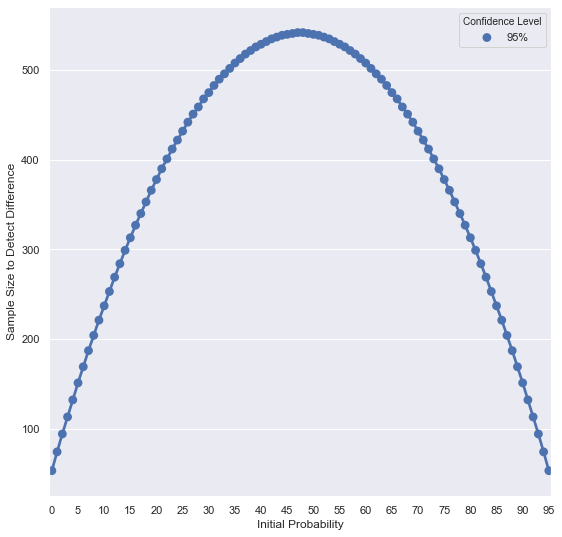

In [8]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(9, 9))
sns.set(style='darkgrid')

plot = sns.pointplot(x='Initial Probability',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)

labels = []
for i in range(0, 101):
    if i % 5 == 0:
        labels.append(str(i))
    else:
        labels.append('')
plot.set_xticklabels(labels=labels)
pyplot.show()

This plot makes it clear that p1 = 50% produces the highest sample sizes.

Using this information, let’s say we want to calculate the sample sizes required to calculate differences in p1 and p2 where p2 - p1 is between 2% and 10%, and confidence levels are 95% or 99%. To ensure we get a sample large enough, we know to set p1 = 50%. We first write the code to build up the data frame to plot.

In [12]:
#Observe probability difference from 2% to 10%
p_diffs = [x*.01 for x in range(1,11)]

data = []
for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial probability'] = '50%'
    data.append(record)

for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.01)
    record['Confidence Level'] = '99%'
    record['Initial probability'] = '50%'
    data.append(record)

df = pd.DataFrame(data)

In [14]:
df.head()

,Confidence Level,Initial probability,Probability Difference,Sample Size to Detect Difference
0,95%,50%,1.0,13527
1,95%,50%,2.0,3381
2,95%,50%,3.0,1502
3,95%,50%,4.0,845
4,95%,50%,5.0,540


Then we write the following code to plot the data with Seaborn.

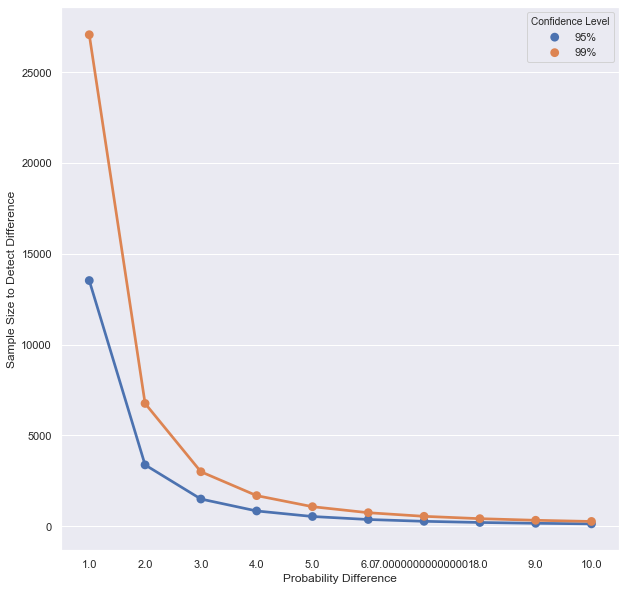

In [13]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(10, 10))

sns.set(style='darkgrid')

plot = sns.pointplot(x='Probability Difference',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)
pyplot.show()

This shows the minimum sample required to detect probability differences between 2% and 10%, for both 95% and 99% confidence levels. So, for example, detecting a difference of 2% at 95% confidence level requires a sample of ~3,500, which translates into n1 = n2 = 1,750. So, in our example, you would need about 1,750 people walking into the store before the marketing intervention, and 1,750 people after to detect a 2% difference in probabilities at a 95% confidence level.

### REFERENCES:

- [[Medium] How to use Python to Figure out Sample Sizes for your Study](https://towardsdatascience.com/how-to-use-python-to-figure-out-sample-sizes-for-your-study-871f0a76a19c)
- [[PennState Univ] Comparing Two Proportions](https://online.stat.psu.edu/stat414/node/268/)